In [71]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

[autoreload of urllib3.packages.six failed: Traceback (most recent call last):
  File "/clusterfs/ml4hep/shahzar/miniconda/envs/multifold/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/clusterfs/ml4hep/shahzar/miniconda/envs/multifold/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/clusterfs/ml4hep/shahzar/miniconda/envs/multifold/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/clusterfs/ml4hep/shahzar/miniconda/envs/multifold/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 310, in update_class
    old_obj = getattr(old, key)
  File "/clusterfs/ml4hep/shahzar/miniconda/envs/multifold/lib/python3.10/site-packages/urllib3/packages/six.py", line 97, in __get__
    setattr(obj, self.name, result)  # Invokes __set__.
AttributeE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of flows.flows failed: Traceback (most recent call last):
  File "/clusterfs/ml4hep/shahzar/miniconda/envs/multifold/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/clusterfs/ml4hep/shahzar/miniconda/envs/multifold/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/clusterfs/ml4hep/shahzar/miniconda/envs/multifold/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/clusterfs/ml4hep/shahzar/reweighting-schemes/flows/flows.py", line 7, in <module>
    import wandb
  File "/clusterfs/ml4hep/shahzar/miniconda/envs/multifold/lib/python3.10/site-packages/wandb/

In [72]:
# General imports
import os
import tensorflow as tf
from scipy import stats

# Utility imports
from utils.losses import *
from utils.plotting import *
from utils.training import *

from flows.flows import *

np.random.seed(666) # Need to do more to ensure data is the same across runs.

In [73]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Corner Plot

In [75]:
mc = np.load("data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

sim_pt =  mc['sim_jets'][:, 0]
sim_eta = mc['sim_jets'][:, 1]
sim_phi = mc['sim_jets'][:, 2]
sim_m =   mc['sim_jets'][:, 3]
sim_mults = mc['sim_mults']
sim_lhas = mc['sim_lhas']
sim_widths = mc['sim_widths']
sim_ang2s = mc['sim_ang2s']
sim_tau2s = mc['sim_tau2s']
sim_sdms = mc['sim_sdms']
sim_zgs = mc['sim_zgs']

In [78]:
import seaborn as sns
import pandas as pd

In [79]:
df = pd.DataFrame(data = {'pt': sim_pt, 'eta': sim_eta, 'phi': sim_phi, 
                          'm': sim_m, 'widths': sim_widths, 'sdms': sim_sdms})

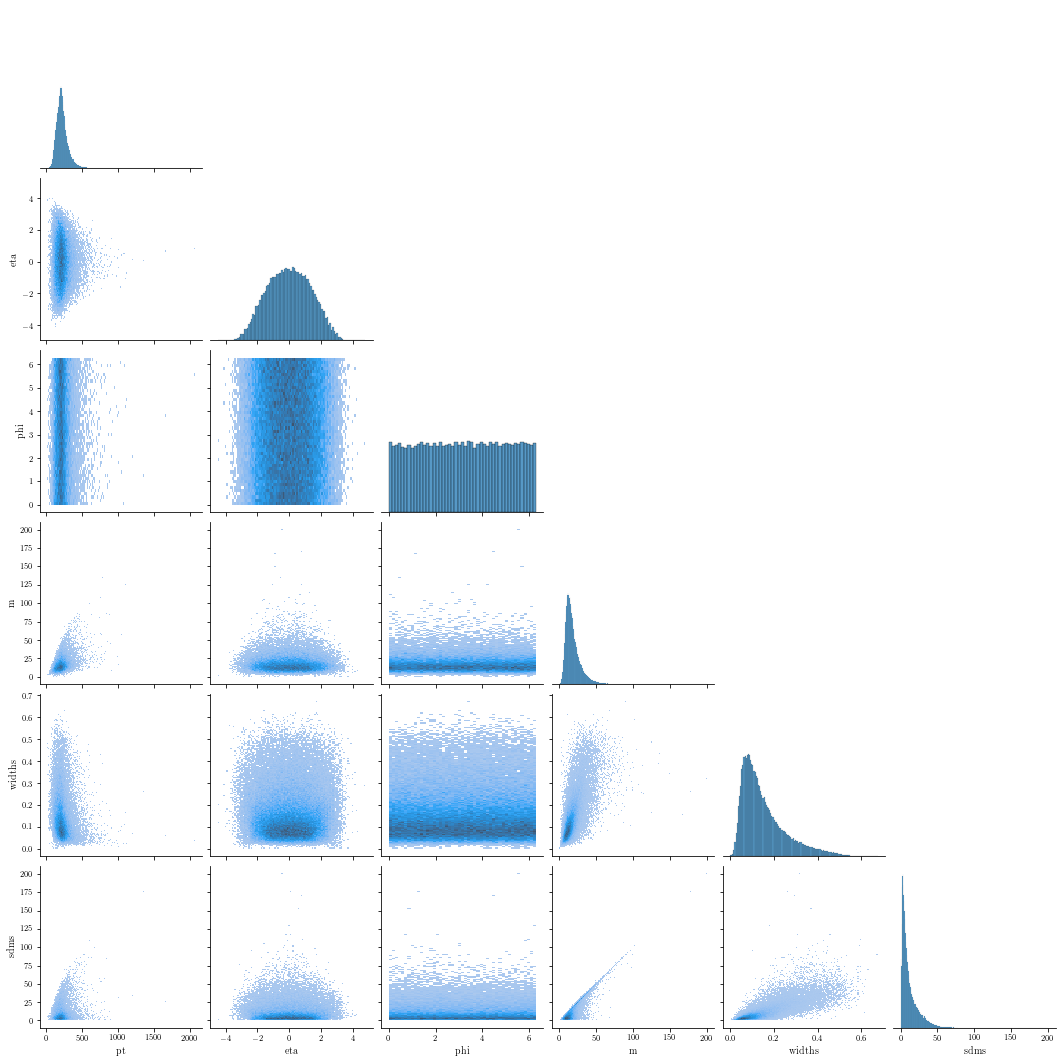

In [84]:
sns.pairplot(data = df, kind = 'hist', corner = True)
plt.savefig('plots/zenodo/corner.pdf')

# Training

## BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':4}
params_2 = {'loss':probit_bce, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'probit/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

if not os.path.isdir(filestr + 'sigmoid/'):
    os.mkdir(filestr + 'sigmoid/')
    
if not os.path.isdir(filestr + 'probit/'):
    os.mkdir(filestr + 'probit/')

if not os.path.isdir(filestr + 'arctan/'):
    os.mkdir(filestr + 'arctan/')

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [ ]:
for i in range(reps):
    print(i, end = ' ')
    model_1, trace = train(data, **params_1)
    model_2, trace = train(data, **params_2)
    model_3, trace = train(data, **params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

## MSE $C$ Parametrization

In [10]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':4}
params_2 = {'loss':probit_mse, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'probit/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

if not os.path.isdir(filestr + 'sigmoid/'):
    os.mkdir(filestr + 'sigmoid/')
    
if not os.path.isdir(filestr + 'probit/'):
    os.mkdir(filestr + 'probit/')

if not os.path.isdir(filestr + 'arctan/'):
    os.mkdir(filestr + 'arctan/')

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [11]:
for i in range(reps):
    print(i, end = ' ')
    model_1, trace = train(data, **params_1)
    model_2, trace = train(data, **params_2)
    model_3, trace = train(data, **params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

0 0.24477393925189972 	 87	0.24475035071372986 	 100	0.2447938770055771 	 93	
1 0.24468831717967987 	 100	0.24479864537715912 	 100	0.2448016256093979 	 91	
2 0.24485065042972565 	 80	0.2447454333305359 	 100	0.24482659995555878 	 100	
3 0.24472790956497192 	 81	0.24474981427192688 	 100	0.24474042654037476 	 100	
4 0.2447977513074875 	 100	0.24482205510139465 	 66	0.2448778748512268 	 96	
5 0.24474984407424927 	 94	0.2447693645954132 	 100	0.24477966129779816 	 100	
6 0.24482056498527527 	 78	0.24477531015872955 	 100	0.24491243064403534 	 92	
7 0.24482500553131104 	 95	0.24480609595775604 	 100	0.24482057988643646 	 79	
8 0.24469053745269775 	 100	0.24474449455738068 	 100	0.24481694400310516 	 100	
9 0.24480943381786346 	 95	0.2447994351387024 	 100	0.24482224881649017 	 100	
10 0.24468518793582916 	 100	0.24484343826770782 	 92	0.2446996569633484 	 100	
11 0.24477875232696533 	 100	0.2447861135005951 	 100	0.24476172029972076 	 100	
12 0.2446480691432953 	 92	0.24486103653907776 	 

## MLC $C$ Parametrization

In [12]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

if not os.path.isdir(filestr + 'relu/'):
    os.mkdir(filestr + 'relu/')
    
if not os.path.isdir(filestr + 'square/'):
    os.mkdir(filestr + 'square/')

if not os.path.isdir(filestr + 'exponential/'):
    os.mkdir(filestr + 'exponential/')

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [13]:
for i in range(reps):
    print(i, end = ' ')
    model_1, trace = train(data, **params_1)
    model_2, trace = train(data, **params_2)
    model_3, trace = train(data, **params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

0 -0.01932302676141262 	 100	-0.017991065979003906 	 93	-0.023603608831763268 	 79	
1 -0.01753956638276577 	 100	-0.019469227641820908 	 100	-0.023996885865926743 	 74	
2 -0.017077920958399773 	 100	-0.017419779673218727 	 100	-0.02423117309808731 	 81	
3 -0.018647940829396248 	 100	-0.01773752085864544 	 100	-0.02478840947151184 	 100	
4 -0.02010597288608551 	 100	-0.018982648849487305 	 100	-0.02428746223449707 	 95	
5 -0.017760466784238815 	 100	0.6996137499809265 	 53	-0.02453874796628952 	 100	
6 -0.017018964514136314 	 100	-0.016546858474612236 	 67	-0.024513116106390953 	 100	
7 -0.01799793913960457 	 100	-0.01760798506438732 	 77	-0.024924401193857193 	 100	
8 -0.020010212436318398 	 100	0.004375128075480461 	 100	-0.024108780547976494 	 85	
9 -0.01757921278476715 	 100	-0.017660105600953102 	 69	-0.024431776255369186 	 100	
10 -0.017294926568865776 	 100	-0.016802923753857613 	 100	-0.02441157028079033 	 100	
11 -0.017208289355039597 	 100	-0.017763212323188782 	 90	-0.0241265

## SQR $C$ Parametrization

In [14]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

if not os.path.isdir(filestr + 'relu/'):
    os.mkdir(filestr + 'relu/')
    
if not os.path.isdir(filestr + 'square/'):
    os.mkdir(filestr + 'square/')

if not os.path.isdir(filestr + 'exponential/'):
    os.mkdir(filestr + 'exponential/')

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [15]:
for i in range(reps):
    print(i, end = ' ')
    model_1, trace = train(data, **params_1)
    model_2, trace = train(data, **params_2)
    model_3, trace = train(data, **params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

0 0.9980277419090271 	 100	1.0963054895401 	 100	0.9891093969345093 	 88	
1 1.0053393840789795 	 100	1.1225228309631348 	 28	0.9888989329338074 	 100	
2 0.9910887479782104 	 100	1.3009840250015259 	 100	0.9888466000556946 	 100	
3 0.9927513599395752 	 100	67.96444702148438 	 34	0.9890287518501282 	 100	
4 0.9937997460365295 	 100	1.1126666069030762 	 39	0.989014208316803 	 100	
5 0.9951557517051697 	 100	11.751347541809082 	 11	0.9892414212226868 	 84	
6 0.9978845119476318 	 100	1.0365170240402222 	 100	0.9890591502189636 	 100	
7 0.9945968985557556 	 100	7.2679572105407715 	 23	0.9889225959777832 	 91	
8 0.9992388486862183 	 100	2.246642827987671 	 28	0.9891905188560486 	 100	
9 1.0025111436843872 	 100	1.3558757305145264 	 38	0.9891601800918579 	 100	
10 0.991354763507843 	 100	1.559239387512207 	 31	0.9891453385353088 	 88	
11 1.0017865896224976 	 100	1.2001080513000488 	 46	0.9887457489967346 	 100	
12 0.9951432347297668 	 100	1.0881400108337402 	 44	0.988896369934082 	 100	
13 0.9

## $p$-MSE

In [53]:
# Physics
#num = 0    # p* search
#num = 1    # p*
num = 2     # p*
reps = 100

# File parameters
filestr = 'models/zenodo/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)
p_star = 1.92

In [54]:
params = {'loss': get_mse(p_star), 'd': 4}
for i in range(reps):
    print(i, end = '\t')
    model, trace = train(data, **params)
    model.save_weights(mse_filestr.format(i))
    print()

0	0.2584822177886963 	 81	
1	0.25847384333610535 	 100	
2	0.2584572434425354 	 100	
3	0.25845643877983093 	 100	
4	0.25845643877983093 	 97	
5	0.2584584951400757 	 100	
6	0.25849199295043945 	 100	
7	0.2585056722164154 	 79	
8	0.2584872841835022 	 100	
9	0.2584959864616394 	 100	
10	0.2584089934825897 	 100	
11	0.2585340142250061 	 100	
12	0.2585195302963257 	 83	
13	0.25863194465637207 	 97	
14	0.2584682106971741 	 90	
15	0.2584628760814667 	 100	
16	0.2586095631122589 	 72	
17	0.25851964950561523 	 80	
18	0.25857090950012207 	 100	
19	0.25849848985671997 	 84	
20	0.25853657722473145 	 91	
21	0.25850167870521545 	 100	
22	0.2585095465183258 	 78	
23	0.2584724724292755 	 95	
24	0.258541464805603 	 79	
25	0.258373498916626 	 100	
26	0.2584589421749115 	 100	
27	0.25842830538749695 	 100	
28	0.25862568616867065 	 75	
29	0.25850483775138855 	 90	
30	0.25844675302505493 	 93	
31	0.2583170235157013 	 100	
32	0.2585471272468567 	 100	
33	0.25858771800994873 	 100	
34	0.2587240934371948 	 94	

## $r$-SQR

In [55]:
# Physics
#num = 0 (r-SQR search)
#num = 1    # r*
num = 2     # r*
reps = 100

# File parameters
filestr = 'models/zenodo/ab_sqr/set_{}/'.format(num)
sqr_filestr = filestr + 'model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

r_star = -0.25

In [56]:
params = {'loss': get_exp_sqr(r_star), 'd': 4, 'output': 'linear'}
for i in range(reps):
    print(i, end = '\t')
    model, trace = train(data, **params)
    model.save_weights(sqr_filestr.format(i))
    print()

0	0.9889824390411377 	 100	
1	0.9890187382698059 	 100	
2	0.9889730215072632 	 100	
3	0.9890350699424744 	 100	
4	0.9889503717422485 	 100	
5	0.9889467358589172 	 100	
6	0.9890879392623901 	 100	
7	0.98903489112854 	 100	
8	0.9889870285987854 	 100	
9	0.9889166951179504 	 100	
10	0.9888890385627747 	 100	
11	0.9890771508216858 	 100	
12	0.9889781475067139 	 100	
13	0.989056408405304 	 100	
14	0.9890078902244568 	 100	
15	0.9888905882835388 	 100	
16	0.9888085722923279 	 100	
17	0.9889366030693054 	 100	
18	0.9889494776725769 	 100	
19	0.9889892339706421 	 100	
20	0.9888144731521606 	 100	
21	0.9889736771583557 	 100	
22	0.9889631867408752 	 100	
23	0.9889138340950012 	 100	
24	0.9888993501663208 	 100	
25	0.9890283346176147 	 100	
26	0.9890933036804199 	 100	
27	0.9888936281204224 	 100	
28	0.9890015721321106 	 94	
29	0.9889786839485168 	 100	
30	0.9889824986457825 	 100	
31	0.9889824986457825 	 100	
32	0.98896324634552 	 100	
33	0.988975465297699 	 100	
34	0.9888792037963867 	 100	
35

# MAEs

In [57]:
d = 4

dat_target = make_target(d)
sim_target = make_target(d)

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

dat_ckpt.restore('flows/dat10/ckpt-534')
sim_ckpt.restore('flows/sim5/ckpt-99')

In [58]:
lr = lambda x: tf.math.exp(dat_target.log_prob(x) - sim_target.log_prob(x)).numpy()

In [59]:
X_mae = np.load('data/zenodo/fold/X_tst.npy')
lr_tst = np.load('data/zenodo/fold/lr_tst.npy')

In [60]:
def mae(model_lr):
    abs_dif = abs(model_lr(X_mae) - lr_tst)
    #print(np.mean(abs_dif < 100), end = ' ')
    return abs_dif[abs_dif < 100].mean()

## BCE

In [33]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':4}
params_2 = {'loss':probit_bce, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'probit/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [39]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = probit_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3, where = ~np.isnan(maes_3))

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

abs_dif_1 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_1])
abs_dif_2 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_2])
abs_dif_3 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_3])

# Save results
np.save(filestr + 'maes_1.npy', maes_1)
np.save(filestr + 'maes_2.npy', maes_2)
np.save(filestr + 'maes_3.npy', maes_3)

np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'abs_dif_1.npy', abs_dif_1)
np.save(filestr + 'abs_dif_2.npy', abs_dif_2)
np.save(filestr + 'abs_dif_3.npy', abs_dif_3)

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

0.14608225 0.14847192 0.14689706
0.0025492029 0.003066189 0.002815044


In [ ]:
abs_dif_1 = np.load(filestr + 'abs_dif_1.npy')
(abs_dif_1 > 100).mean()

In [ ]:
aa = abs_dif_1.flatten()
bb = abs_dif_2.flatten()
cc = abs_dif_3.flatten()

ts = np.linspace(0, 20)
plt.plot(ts, [(aa < t).mean() for t in ts], label = r'$\sigma(z)$')
plt.plot(ts, [(bb < t).mean() for t in ts], label = r'$\frac{1}{2}\left(\tanh{z} + 1\right)$')
plt.plot(ts, [(cc < t).mean() for t in ts], label = r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$')
plt.legend()

plt.xlabel(r'$t$')
plt.ylabel(r'$\text{Pr}\left(\Big|\mathcal{L}(X) - \mathcal{L}_\text{BCE}(X)\Big| < t\right)$')
plt.title(r'BCE Likelihood Ratios Absolute Differences')

plt.savefig('plots/zenodo/bce_threshold_plot.png', 
            dpi=300, 
            bbox_inches='tight')

## MSE

In [40]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':4}
params_2 = {'loss':probit_mse, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'probit/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [41]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = probit_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3, where = ~np.isnan(maes_3))

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

abs_dif_1 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_1])
abs_dif_2 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_2])
abs_dif_3 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_3])

# Save results
np.save(filestr + 'maes_1.npy', maes_1)
np.save(filestr + 'maes_2.npy', maes_2)
np.save(filestr + 'maes_3.npy', maes_3)

np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'abs_dif_1.npy', abs_dif_1)
np.save(filestr + 'abs_dif_2.npy', abs_dif_2)
np.save(filestr + 'abs_dif_3.npy', abs_dif_3)

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

0.14616878 0.14835376 0.14759414
0.002584857 0.0028666363 0.0025263757


In [ ]:
abs_dif_1 = np.load(filestr + 'abs_dif_1.npy')
(abs_dif_1 > 100).mean()

In [ ]:
aa = abs_dif_1.flatten()
bb = abs_dif_2.flatten()
cc = abs_dif_3.flatten()

ts = np.linspace(0, 20)
plt.plot(ts, [(aa < t).mean() for t in ts], label = r'$\sigma(z)$')
plt.plot(ts, [(bb < t).mean() for t in ts], label = r'$\frac{1}{2}\left(\tanh{z} + 1\right)$')
plt.plot(ts, [(cc < t).mean() for t in ts], label = r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$')
plt.legend()

plt.xlabel(r'$t$')
plt.ylabel(r'$\text{Pr}\left(\Big|\mathcal{L}(X) - \mathcal{L}_\text{MSE}(X)\Big| < t\right)$')
plt.title(r'MSE Likelihood Ratios Absolute Differences')

plt.savefig('plots/zenodo/mse_threshold_plot.png', 
            dpi=300, 
            bbox_inches='tight')

## MLC

In [42]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [43]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3, where = ~np.isnan(maes_3))

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

abs_dif_1 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_1])
abs_dif_2 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_2])
abs_dif_3 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_3])

# Save results
np.save(filestr + 'maes_1.npy', maes_1)
np.save(filestr + 'maes_2.npy', maes_2)
np.save(filestr + 'maes_3.npy', maes_3)

np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'abs_dif_1.npy', abs_dif_1)
np.save(filestr + 'abs_dif_2.npy', abs_dif_2)
np.save(filestr + 'abs_dif_3.npy', abs_dif_3)

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

0.2011158 0.23684657 0.14674902
0.007720558 0.12721361 0.0033592337


In [ ]:
abs_dif_3 = np.load(filestr + 'abs_dif_3.npy')
(abs_dif_3 > 100).mean()

In [ ]:
aa = abs_dif_1.flatten()
bb = abs_dif_2.flatten()
cc = abs_dif_3.flatten()

ts = np.linspace(0, 20)
plt.plot(ts, [(aa < t).mean() for t in ts], label = r'${\rm ReLU}(z)$')
plt.plot(ts, [(bb < t).mean() for t in ts], label = r'$z^2$')
plt.plot(ts, [(cc < t).mean() for t in ts], label = r'$\exp(z)$')
plt.legend()

plt.xlabel(r'$t$')
plt.ylabel(r'$\text{Pr}\left(\Big|\mathcal{L}(X) - \mathcal{L}_\text{MLC}(X)\Big| < t\right)$')
plt.title(r'MLC Likelihood Ratios Absolute Differences')

plt.savefig('plots/zenodo/mlc_threshold_plot.png', 
            dpi=300, 
            bbox_inches='tight')

## SQR

In [44]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [45]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2, where = ~np.isnan(maes_2))
avg_3 = np.mean(maes_3, where = ~np.isnan(maes_3))

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1, where = ~np.isnan(maes_2))
std_3 = np.std(maes_3, ddof = 1)

abs_dif_1 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_1])
abs_dif_2 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_2])
abs_dif_3 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_3])

# Save results
np.save(filestr + 'maes_1.npy', maes_1)
np.save(filestr + 'maes_2.npy', maes_2)
np.save(filestr + 'maes_3.npy', maes_3)

np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'abs_dif_1.npy', abs_dif_1)
np.save(filestr + 'abs_dif_2.npy', abs_dif_2)
np.save(filestr + 'abs_dif_3.npy', abs_dif_3)

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

/tmp/ipykernel_13615/3780721232.py:4: RuntimeWarning: Mean of empty slice.
  return abs_dif[abs_dif < 100].mean()
/clusterfs/ml4hep/shahzar/miniconda/envs/multifold/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


0.26831406 0.80117816 0.14629832
0.050722536 0.18551055 0.0025390913


In [ ]:
abs_dif_3 = np.load(filestr + 'abs_dif_3.npy')
(abs_dif_3 > 100).mean()

In [ ]:
aa = abs_dif_1.flatten()
bb = abs_dif_2.flatten()
cc = abs_dif_3.flatten()

ts = np.linspace(0, 20)
plt.plot(ts, [(aa < t).mean() for t in ts], label = r'${\rm ReLU}(z)$')
plt.plot(ts, [(bb < t).mean() for t in ts], label = r'$z^2$')
plt.plot(ts, [(cc < t).mean() for t in ts], label = r'$\exp(z)$')
plt.legend()

plt.xlabel(r'$t$')
plt.ylabel(r'$\text{Pr}\left(\Big|\mathcal{L}(X) - \mathcal{L}_\text{SQR}(X)\Big| < t\right)$')
plt.title(r'SQR Likelihood Ratios Absolute Differences')

plt.savefig('plots/zenodo/sqr_threshold_plot.png', 
            dpi=300, 
            bbox_inches='tight')

## AB MSE

In [46]:
# Experiment parameters
num = 2
reps = 20

# File parameters
filestr = 'models/zenodo/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

In [47]:
# Get model likelihood ratios.
avgs = []
for p in ps:
    print(p, end = '\t')
    lrs = [None] * reps
    params = {'loss':get_mse(p), 'd': 4}
    for i in range(reps):
        model = create_model(**params)
        model.load_weights(mse_filestr.format(p, i))
        lrs[i] = pow_odds_lr(model, p, m, s)
    
    maes = [mae(lr) for lr in lrs]
    avgs += [np.mean(maes)]

avgs = np.array(avgs)

-2.0	-1.96	-1.92	-1.88	-1.84	-1.8	-1.76	-1.72	-1.68	-1.64	-1.6	-1.56	-1.52	-1.48	-1.44	-1.4	-1.36	-1.32	-1.28	-1.24	-1.2	-1.16	-1.12	-1.08	-1.04	-1.0	-0.96	-0.92	-0.88	-0.84	-0.8	-0.76	-0.72	-0.68	-0.64	-0.6	-0.56	-0.52	-0.48	-0.44	-0.4	-0.36	-0.32	-0.28	-0.24	-0.2	-0.16	-0.12	-0.08	-0.04	0.0	0.04	

/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:235: RuntimeWarning: divide by zero encountered in divide
  return model_lr
/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:235: RuntimeWarning: divide by zero encountered in power
  return model_lr
/tmp/ipykernel_13615/3780721232.py:2: RuntimeWarning: invalid value encountered in subtract
  abs_dif = abs(model_lr(X_mae) - lr_tst)
/tmp/ipykernel_13615/3780721232.py:4: RuntimeWarning: Mean of empty slice.
  return abs_dif[abs_dif < 100].mean()


0.08	0.12	0.16	0.2	0.24	0.28	0.32	0.36	0.4	0.44	0.48	0.52	0.56	0.6	0.64	0.68	0.72	0.76	0.8	0.84	0.88	0.92	0.96	1.0	1.04	1.08	1.12	1.16	1.2	1.24	1.28	1.32	1.36	1.4	1.44	1.48	1.52	1.56	1.6	1.64	1.68	1.72	1.76	1.8	1.84	1.88	1.92	1.96	2.0	

In [48]:
# Save results
np.save(filestr + 'avgs', avgs)

In [5]:
avgs = np.load(filestr + 'avgs.npy')

In [10]:
ps[avgs == np.nanmin(avgs)]

array([-0.28])

In [ ]:
w = 3.5
h = 3.25              # Plots have dimension (w,h)

plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
plt.ylim(0, 1.25)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_zenodo.png', 
            dpi=300, 
            bbox_inches='tight')

## AB SQR

In [49]:
# Experiment parameters
num = 2
reps = 20

# File parameters
filestr = 'models/zenodo/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

In [50]:
lin_avgs = []
exp_avgs = []

for r in rs:
    print(r, end = '\t')
    lin_lrs = [None] * reps
    exp_lrs = [None] * reps
    lin_params = {'loss': get_sqr(r), 'd': 4, 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(r), 'd': 4, 'output':'linear'}
    
    for i in range(reps):
        lin_model = create_model(**lin_params)
        exp_model = create_model(**exp_params)
        
        lin_model.load_weights(lin_filestr.format(r, i))
        exp_model.load_weights(exp_filestr.format(r, i))
        
        lin_lrs[i] = pow_lr(lin_model, r, m, s)
        exp_lrs[i] = pow_exp_lr(exp_model, r, m, s)
    
    lin_maes = [mae(lr) for lr in lin_lrs]
    exp_maes = [mae(lr) for lr in exp_lrs]
    
    lin_avgs += [np.mean(lin_maes)]
    exp_avgs += [np.mean(exp_maes)]

-2.0	-1.95	-1.9	-1.85	-1.8	-1.75	-1.7	-1.65	-1.6	-1.55	-1.5	-1.45	-1.4	-1.35	

/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:223: RuntimeWarning: divide by zero encountered in power
  return model_lr


-1.3	-1.25	-1.2	-1.15	-1.1	-1.05	-1.0	

/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:223: RuntimeWarning: divide by zero encountered in reciprocal
  return model_lr


-0.95	-0.9	-0.85	

/tmp/ipykernel_13615/3780721232.py:2: RuntimeWarning: invalid value encountered in subtract
  abs_dif = abs(model_lr(X_mae) - lr_tst)


-0.8	-0.75	-0.7	-0.65	-0.6	-0.5	-0.45	-0.35	-0.15	-0.1	-0.05	-0.046	-0.042	-0.038	-0.034	-0.03	-0.026	

/tmp/ipykernel_13615/3780721232.py:4: RuntimeWarning: Mean of empty slice.
  return abs_dif[abs_dif < 100].mean()


-0.022	-0.018	-0.014	-0.01	-0.006	-0.002	0.0	0.002	0.006	0.01	0.014	0.018	0.022	0.026	0.03	0.034	0.038	0.042	0.046	0.05	0.1	0.15	0.2	0.25	0.3	0.35	0.4	0.45	0.5	0.55	0.6	0.65	0.7	0.75	0.8	0.85	0.9	0.95	1.0	1.05	1.1	1.15	1.2	1.25	1.3	1.35	1.4	1.45	1.5	1.55	1.6	1.65	1.7	1.75	1.8	1.85	1.9	1.95	2.0	

In [51]:
# Save results
lin_avgs = np.array(lin_avgs)
exp_avgs = np.array(exp_avgs)

np.save(filestr + 'lin_avgs', lin_avgs)
np.save(filestr + 'exp_avgs', exp_avgs)

In [52]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([0.25]), array([-0.25]))

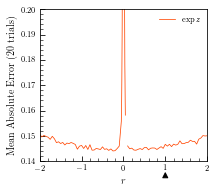

In [70]:
w = 3
h = 2.8

plt.figure(figsize = (w, h))

plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='orangered', lw = 0.75)
plt.legend(frameon = False)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error (20 trials)')
plt.xlabel(r'$r$')
plt.ylim(0.14, 0.2)
plt.xlim(-2, 2)
plt.gca().annotate(' ', (1.0, 0.14 - 0.0045), 
                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
                   annotation_clip = False)

#plt.title(r"\it $r$-SQR Losses for Physics Data", loc="right");
plt.savefig('plots/paper/rsqr_physics.pdf', 
            dpi=300, 
            bbox_inches='tight')

## $p^*$-MSE

In [61]:
# Physics
#num = 0    # p* search
num = 2    # p*
reps = 100

# File parameters
filestr = 'models/zenodo/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)
p_star = 1.92

In [62]:
lrs = [None] * reps
params = {'loss':get_mse(p_star), 'd': 4}

for i in range(reps):
    print(i, end = '\t')
    model = create_model(**params)
    model.load_weights(mse_filestr.format(i))
    lrs[i] = pow_odds_lr(model, p_star, m, s)

# Calculate mean absolute errors
maes = np.array([mae(lr) for lr in lrs])

# Save results
np.save(filestr + 'maes.npy', maes)
print(np.mean(maes), np.std(maes, ddof = 1) / 10)

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	0.14603195 0.00030332948081195353


## $r^*$-SQR

In [65]:
# Physics
#num = 0 (r-SQR search)
num = 2    # r*
reps = 100

# File parameters
filestr = 'models/zenodo/ab_sqr/set_{}/'.format(num)
sqr_filestr = filestr + 'model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

r_star = -0.25

In [66]:
lrs = [None] * reps
params = {'loss':get_exp_sqr(r_star), 'd': 4, 'output': 'linear'}

for i in range(reps):
    print(i, end = '\t')
    model = create_model(**params)
    model.load_weights(sqr_filestr.format(i))
    lrs[i] = pow_exp_lr(model, r_star, m, s)

# Calculate mean absolute errors
maes = np.array([mae(lr) for lr in lrs])

# Save results
np.save(filestr + 'maes.npy', maes)
print(np.mean(maes), np.std(maes, ddof = 1) / 10)

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	0.14465256 0.0001573489513248205


# Check NaNs

## BCE

In [ ]:
# Experiment parameters
num = 0
filestr = 'models/zenodo/c_bce/set_{}/'.format(num)

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
X_mae = np.load('data/zenodo/fold/' + 'X_tst.npy')
abs_dif_1 = np.load(filestr + 'abs_dif_1.npy')

In [ ]:
bad = X_mae[np.any(abs_dif_1 > 100, axis = 0)]

In [ ]:
plt.scatter(X[:, 0], X[:, 1], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 0], bad[:, 1], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$p_T$')
plt.ylabel(r'$\eta$')
plt.title('Points with BCE MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/bce_pt_eta.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 0], X[:, 2], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 0], bad[:, 2], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$p_T$')
plt.ylabel(r'$\phi$')
plt.title('Points with BCE MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/bce_pt_phi.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 0], X[:, 3], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 0], bad[:, 3], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$p_T$')
plt.ylabel(r'$m$')
plt.title('Points with BCE MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/bce_pt_m.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 1], X[:, 2], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 1], bad[:, 2], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\phi$')
plt.title('Points with BCE MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/bce_eta_phi.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 1], X[:, 3], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 1], bad[:, 3], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$m$')
plt.title('Points with BCE MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/bce_eta_m.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 2], X[:, 3], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 2], bad[:, 3], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$m$')
plt.title('Points with BCE MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/bce_phi_m.png', 
            dpi=300, 
            bbox_inches='tight')

## MLC

In [ ]:
# Experiment parameters
num = 0
filestr = 'models/zenodo/c_mlc/set_{}/'.format(num)

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
X_mae = np.load('data/zenodo/fold/' + 'X_tst.npy')
abs_dif_1 = np.load(filestr + 'abs_dif_1.npy')

In [ ]:
bad = X_mae[np.any(abs_dif_1 > 100, axis = 0)]

In [ ]:
plt.scatter(X[:, 0], X[:, 1], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 0], bad[:, 1], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$p_T$')
plt.ylabel(r'$\eta$')
plt.title('Points with MLC MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/mlc_pt_eta.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 0], X[:, 2], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 0], bad[:, 2], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$p_T$')
plt.ylabel(r'$\phi$')
plt.title('Points with MLC MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/mlc_pt_phi.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 0], X[:, 3], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 0], bad[:, 3], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$p_T$')
plt.ylabel(r'$m$')
plt.title('Points with MLC MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/mlc_pt_m.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 1], X[:, 2], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 1], bad[:, 2], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\phi$')
plt.title('Points with MLC MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/mlc_eta_phi.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 1], X[:, 3], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 1], bad[:, 3], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$m$')
plt.title('Points with MLC MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/mlc_eta_m.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 2], X[:, 3], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 2], bad[:, 3], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$m$')
plt.title('Points with MLC MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/mlc_phi_m.png', 
            dpi=300, 
            bbox_inches='tight')

# Random Slice

In [7]:
X = np.load('data/zenodo/fold/X_trn.npy')
y = np.load('data/zenodo/fold/y_trn.npy')

In [8]:
stats.mode(X)

ModeResult(mode=array([[218.1418   ,  -2.0407841,   4.4148946,  22.070618 ]],
      dtype=float32), count=array([[9, 6, 8, 9]]))

In [9]:
mode_pT = 218
mode_eta = 0
mode_phi = 4.4
mode_m = 22

## $\phi$ Scan

In [10]:
# Get a one-dimensional slice of test points.
phis = np.linspace(0, 2*np.pi, 1201).reshape(-1, 1)
pTs = np.repeat(mode_pT, len(phis)).reshape(-1, 1)
etas = np.repeat(mode_eta, len(phis)).reshape(-1, 1)
ms = np.repeat(mode_m, len(phis)).reshape(-1, 1)

xs = np.hstack([pTs, etas, phis, ms])
var = phis
var_label = r'$\phi$'
var_string = 'phi'

lr_true = lr(xs)

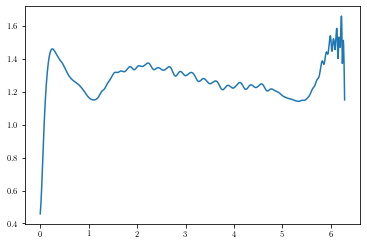

In [11]:
plt.plot(phis, lr_true)

### BCE

In [34]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':4}
params_2 = {'loss':tanh_bce, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 3)
title = r'\it BCE $\phi$ Scan'
filename = 'plots/zenodo/scans/bce_phi.png'

In [35]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [36]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [37]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

In [38]:
cs = ['crimson', 'orangered', 'darkorange']
lss = [':', '--', '-.']

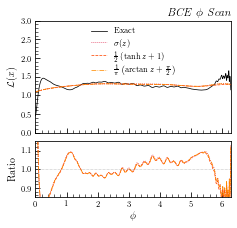

In [39]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')
axs[0].legend(frameon = False)

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.85, 1.15);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### MSE

In [17]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':4}
params_2 = {'loss':tanh_mse, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 3)
title = r'\it MSE $\phi$ Scan'
filename = 'plots/zenodo/scans/mse_phi.png'

In [18]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [19]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [20]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

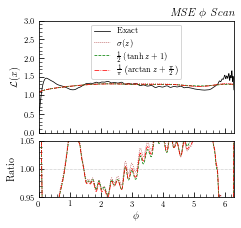

In [21]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.85, 1.15);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### MLC

In [22]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 3)
title = r'\it MLC $\phi$ Scan'
filename = 'plots/zenodo/scans/mlc_phi.png'

In [23]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [24]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [25]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

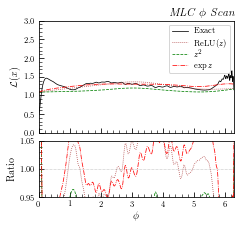

In [26]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### SQR

In [27]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 3)
title = r'\it SQR $\phi$ Scan'
filename = 'plots/zenodo/scans/sqr_phi.png'

In [28]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [29]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [30]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

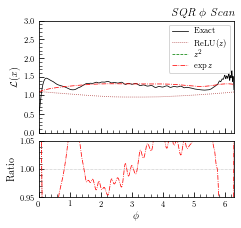

In [31]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.85, 1.15);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

## $p_T$ Scan

In [68]:
# Get a one-dimensional slice of test points.
pTs = np.linspace(0, 750, 1201).reshape(-1, 1)
etas = np.repeat(mode_eta, len(pTs)).reshape(-1, 1)
phis = np.repeat(mode_phi, len(pTs)).reshape(-1, 1)
ms = np.repeat(mode_m, len(pTs)).reshape(-1, 1)

xs = np.hstack([pTs, etas, phis, ms])
var = pTs
var_label = r'$p_T$'
var_string = 'pT'

lr_true = lr(xs)

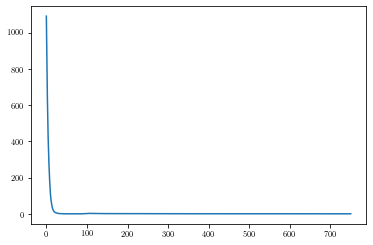

In [69]:
plt.plot(pTs, lr_true)

### BCE

In [70]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':4}
params_2 = {'loss':tanh_bce, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 3)
title = r'\it BCE $\phi$ Scan'
filename = 'plots/zenodo/scans/bce_phi.png'

In [71]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [72]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [73]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

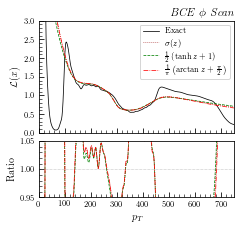

In [74]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### MSE

In [75]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':4}
params_2 = {'loss':tanh_mse, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 3)
title = r'\it MSE $\p_T$ Scan'
filename = 'plots/zenodo/scans/mse_phi.png'

In [76]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [77]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [78]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

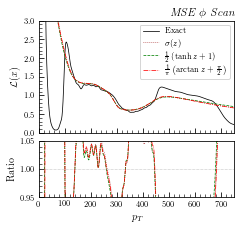

In [79]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### MLC

In [80]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 3)
title = r'\it MLC $\phi$ Scan'
filename = 'plots/zenodo/scans/mlc_phi.png'

In [81]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [82]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [83]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

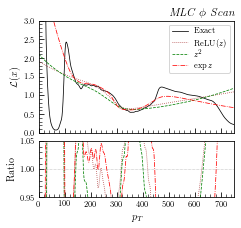

In [84]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### SQR

In [85]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 3)
title = r'\it MLC $\phi$ Scan'
filename = 'plots/zenodo/scans/mlc_phi.png'

In [86]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [87]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [88]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

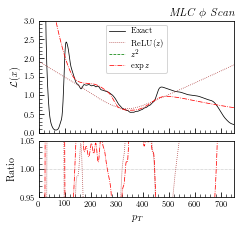

In [89]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

## $\eta$ Scan

In [90]:
# Get a one-dimensional slice of test points.
etas = np.linspace(-5, 5, 1001).reshape(-1, 1)
pTs = np.repeat(mode_pT, len(etas)).reshape(-1, 1)
phis = np.repeat(mode_phi, len(etas)).reshape(-1, 1)
ms = np.repeat(mode_m, len(etas)).reshape(-1, 1)

xs = np.hstack([pTs, etas, phis, ms])
var = etas
var_label = r'$\eta$'
var_string = 'eta'

lr_true = lr(xs)

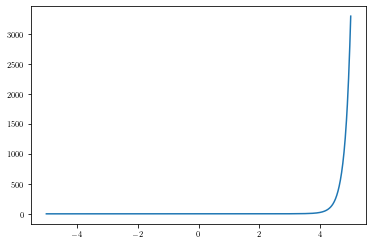

In [91]:
plt.plot(etas, lr_true)

### BCE

In [92]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':4}
params_2 = {'loss':tanh_bce, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 3)
title = r'\it BCE $\phi$ Scan'
filename = 'plots/zenodo/scans/bce_phi.png'

In [93]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [94]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [95]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

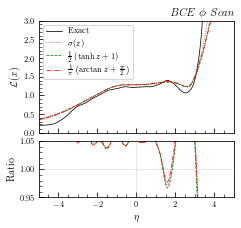

In [96]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### MSE

In [97]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':4}
params_2 = {'loss':tanh_mse, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 3)
title = r'\it MSE $\phi$ Scan'
filename = 'plots/zenodo/scans/mse_phi.png'

In [98]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [99]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [100]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

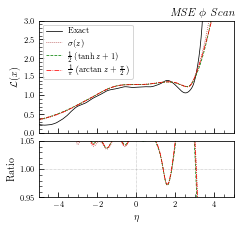

In [101]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### MLC

In [102]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 3)
title = r'\it MLC $\phi$ Scan'
filename = 'plots/zenodo/scans/mlc_phi.png'

In [103]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [104]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [105]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

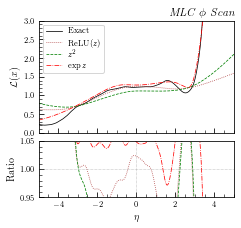

In [106]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### SQR

In [107]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 3)
title = r'\it MLC $\phi$ Scan'
filename = 'plots/zenodo/scans/mlc_phi.png'

In [108]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [109]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [110]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

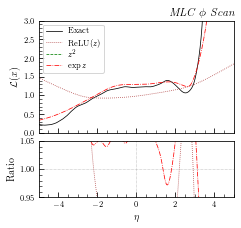

In [111]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

## $m$ Scan

In [112]:
# Get a one-dimensional slice of test points.
ms = np.linspace(0, 80, 1001).reshape(-1, 1)
pTs = np.repeat(mode_pT, len(ms)).reshape(-1, 1)
phis = np.repeat(mode_phi, len(ms)).reshape(-1, 1)
etas = np.repeat(mode_eta, len(ms)).reshape(-1, 1)

xs = np.hstack([pTs, etas, phis, ms])
var = ms
var_label = r'$m$'
var_string = 'm'

lr_true = lr(xs)

lr_true = lr(xs)

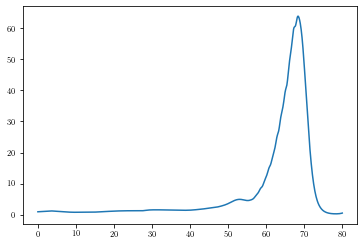

In [113]:
plt.plot(ms, lr_true)

### BCE

In [114]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':4}
params_2 = {'loss':tanh_bce, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 3)
title = r'\it BCE $\phi$ Scan'
filename = 'plots/zenodo/scans/bce_phi.png'

In [115]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [116]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [117]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

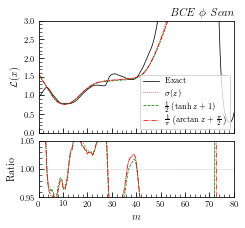

In [118]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### MSE

In [119]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':4}
params_2 = {'loss':tanh_mse, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 3)
title = r'\it MSE $\phi$ Scan'
filename = 'plots/zenodo/scans/mse_phi.png'

In [120]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [121]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [122]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

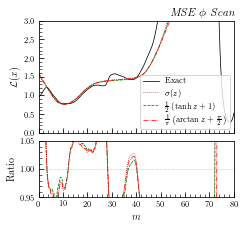

In [123]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### MLC

In [124]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 3)
title = r'\it MLC $\phi$ Scan'
filename = 'plots/zenodo/scans/mlc_phi.png'

In [125]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [126]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [127]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

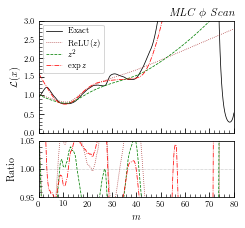

In [128]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### SQR

In [129]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 3)
title = r'\it MLC $\phi$ Scan'
filename = 'plots/zenodo/scans/mlc_phi.png'

In [130]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [131]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [132]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

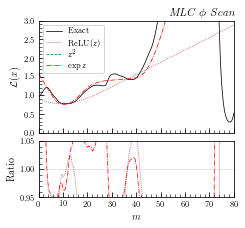

In [133]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')